In [1]:
import pandas as pd
import numpy as np
import os
import pickle
import sys
from sklearn.neighbors import KNeighborsClassifier  
import matplotlib.pyplot as plt
import networkx as nx
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
%load_ext autoreload
%autoreload 2
from sklearn.tree import DecisionTreeClassifier
import time
from db.database import DatabaseConnector
from dtloader.dataloader import DataLoader
from sklearn.model_selection import cross_val_score
from statsmodels.tsa.stattools import grangercausalitytests
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from utils.utils import *
import seaborn as sns
from granger.grangercausality_reg import GrangerCausalityTest
from granger.grangercausality_cl import GrangerCausalityDiscrete
from segmentation.segmentation import *
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.tsatools import lagmat2ds
import statsmodels.api as sm
from statsmodels.tools.tools import add_constant
from utils.features_eng import *
from scipy import stats
from sklearn.model_selection import cross_val_score
from statsmodels.tsa.stattools import grangercausalitytests
import warnings
warnings.filterwarnings('ignore')

In [2]:
#connecting to the database 
dl = DataLoader()
dl.load('../sample_testing/sample2.log')
dl.extractinfo(export=False,single_file=False)

mongodb://localhost:27017/
Database connected


In [3]:
#dl.dbconnector.query_str('sample2')

In [4]:
pd.DataFrame(dl.dbconnector.query('GPS_sample_testing/sample2')).head()

,_id,TimeUS,Status,GMS,GWk,NSats,HDop,Lat,Lng,RAlt,Alt,Spd,GCrs,VZ,GPS_0,lineIndex
0,5cfd4a85048d2b431094bd28,216191643,3,66089600,1950,7,1.28,56.590823,37.201885,0.00,123.81,0.11,328.3,-0.22,1,611
1,5cfd4a85048d2b431094bd28,216212018,3,66090200,1950,7,1.28,56.590823,37.201885,0.00,123.81,0.03,328.3,-0.15,1,616
2,5cfd4a85048d2b431094bd28,216271200,3,66090200,1950,7,1.28,56.590821,37.201886,0.01,124.23,0.06,328.3,0.03,1,621
3,5cfd4a85048d2b431094bd28,216471200,3,66092200,1950,7,1.28,56.590821,37.201886,0.00,124.28,0.09,328.3,0.03,1,669
4,5cfd4a85048d2b431094bd28,216671445,3,66092400,1950,7,1.28,56.590821,37.201886,-0.04,124.30,0.04,328.3,-0.10,1,719


## Granger Causality Sample Testing

For this test we need to put the two variables in one table with the line indexes and then test everything 

In [24]:
def signal_comp_va(signal_name):
    return  signal_name[:signal_name.index('_')],signal_name[signal_name.index('_')+1:]

def ft_eg(signal_name,sr,segmts,lag=5):
    """
    given a continuous series return a dataframe with added features
    methods are implemented in the file feature_eng.py in the utils directory
    """
    seg_ratio = segment_ratio(sr, segmts)
    seg_means = segment_mean(sr,segmts)
    seg_median = segment_median(sr,segmts)
    seg_ratio_perc = segment_ratio_outlier(seg_ratio)
    moving_avg_data = moving_average_window(sr, 10)
    lagged_segments = lagged_segment(sr, segmts) #lagged segment ratios
    lagged_percentile = seg_ratio_perc.shift(lag).fillna(method='bfill')
    
    lagged_seg_means = seg_means.shift(lag).fillna(method='bfill')
    lagged_seg_median = seg_median.shift(lag).fillna(method='bfill')
    lagged_mov_avg = moving_avg_data.shift(lag).fillna(method='bfill')
    
    dataset = pd.DataFrame()
    #dataset['seg_ratio'] = seg_ratio
    #dataset['seg_ratio_percentile'] = seg_ratio_perc
    dataset[signal_name+'_lagged_moving_avg'] = lagged_mov_avg
    #dataset[signal_name+'_lagged_segments'] = lagged_segments
    #dataset[signal_name+'_lagged_perc'] = lagged_percentile
    dataset[signal_name+'_lagged_means'] = lagged_seg_means
    dataset[signal_name+'_lagged_medians'] = lagged_seg_median
    return dataset

def segment_signal(comp,va,dl,filename):
    """
    return a segment list of the signal
    """
    sg = Segmentation(2)
    fitmethod= 'inter'
    sgmethod = 'td'
    sr = dl.dbconnector.query(comp+'_' + filename,va)
    if isinstance(sr,int) or sr is None:
        return -1
    sig_length = len(sr)
    rng = dl.dbconnector.query(comp+'_'+filename,'lineIndex')
    try:
        segments = sg.segment(sr,seg_method=sgmethod,fit_method=fitmethod,err_growth=0.6,batch=True,batch_size=50)
    except:
        return -1
    return segments


def align_index(filename,comp_x,va_x,comp_z,va_z):
    #aligning the time index of the two signals
    #---------------------------------------------------------------------------
    ts = {comp_x:[va_x],comp_z:[va_z]}
    dft = corr_var(filename,dl,ts,find_corr=False)
    dft.reset_index(inplace=True)
    dft.drop('lineIndex',axis=1,inplace=True)
    dft.dropna(axis=0,how='any',inplace=True) #remove nans
    dft.index = range(len(dft))
    #for variables with the same keys we add the other manaully    
    #to be fixed later
    if len(dft.columns) == 1:
        #same key case - add the other to the dataframe
        dft[comp_x+'_'+va_x] = dl.dbconnector.query(comp_x+'_'+filename,va_x)
    return dft

In [25]:
def causality_cls_preprocess(x,y,z,filename, lag):
    """
    preprocess data to put it in the write form for granger test using classification

    :param filename : log file to process
    :param lag: lag value for features 

    """
    # segmenting signals
    # not loading from database to test different segments with max error and batch sizes
    # ------------------------------------------------------------------------------------
    # segment x
    comp_x, va_x = signal_comp_va(x)
    seg_x = segment_signal(comp_x, va_x, dl, filename)

    # segment y
    comp_y, va_y = signal_comp_va(y)
    seg_y = segment_signal(comp_y, va_y, dl, filename)

    # segment z
    comp_z, va_z = signal_comp_va(z)
    seg_z = segment_signal(comp_z, va_z, dl, filename)
    if seg_x == -1 or seg_y == -1 or seg_z == -1:
        return -1,-1,-1,-1,-1,-1,-1,-1,-1
    # align time index between two files
    dft = align_index(filename, comp_x, va_x, comp_z, va_z)
    dft_y = align_index(filename, comp_y, va_y, comp_z, va_z)

    # datasets containing the features for predictions
    # Adding features
    # ---------------------------------------------------------------------------
    dataset_x = ft_eg(comp_x+'_'+va_x, dft[comp_x+'_'+va_x], seg_x, lag=lag)
    dataset_y = ft_eg(comp_y+'_'+va_y, dft_y[comp_y+'_'+va_y], seg_y, lag=lag)
    dataset_z = ft_eg(comp_z+'_'+va_z, dft[comp_z+'_'+va_z], seg_z, lag=lag)

    # Building the target variable for z
    # ---------------------------------------------------------------------------
    seg_ratio_z = segment_ratio(dft[comp_z+'_'+va_z], seg_z)
    target = np.zeros_like(seg_ratio_z)
    threshold_event_occurred = -0.01  # Event = Massive  drop
    idx = event_finder(seg_ratio_z, threshold_event_occurred, "lesser")
    target[idx] = -1
    threshold_event_occurred = 0.01  # Event = Massive  rise
    idx = event_finder(seg_ratio_z, threshold_event_occurred, "greater")
    target[idx] = 1
    
    
    #if another variable was used the segments will not be equal to the lineindex concat so another must be constructed
    seg_ratio_z = segment_ratio(dft_y[comp_z+'_'+va_z], seg_z)
    target_y = np.zeros_like(seg_ratio_z)
    threshold_event_occurred = -0.01  # Event = Massive  drop
    idx = event_finder(seg_ratio_z, threshold_event_occurred, "lesser")
    target_y[idx] = -1
    threshold_event_occurred = 0.01 # Event = Massive  rise
    idx = event_finder(seg_ratio_z, threshold_event_occurred, "greater")
    target_y[idx] = 1

    # combining features for full model
    # ---------------------------------------------------------------------------
    dataset_combined_xz = pd.concat([dataset_x, dataset_z], axis=1).dropna()
    dataset_combined_yz = pd.concat([dataset_y, dataset_z], axis=1).dropna()
    return dft, dft_y, dataset_x, dataset_y, dataset_z, dataset_combined_xz, dataset_combined_yz, target,target_y


def test_causality(df, comp_x, va_x, dataset_red, dataset_combined, comp_z, va_z, target,cv):
    l = ['nb', 'dt', 'knn', 'lr']
    gcl = GrangerCausalityDiscrete(
        names=[comp_x+'_'+va_x, comp_x+' +' + comp_z])
    dict_cls = {}
    for cls in l:
        res = gcl.test(df[comp_x+'_'+va_x], df[comp_z+'_'+va_z], dataset_red, dataset_combined, target, check_stationary=False,
                       classifier=cls, verbose=False, cv=cv)
        dict_cls[cls] = {'Mean-Acc-Full': gcl.mean_full,
                         'Mean-Acc-Reduced': gcl.mean_reduced, 'P-Value': gcl.pvalue}
    return dict_cls

In [7]:
x = 'RCIN_C3'
y = 'RCIN_C1'
z = 'BARO_Alt'

# X Causes Z

In [8]:
filename = 'sample_testing/sample2'
lag = 25
cv = 12

In [9]:
mean_acc_full_list = []
mean_acc_red_list = []
p_value_list = []
for cv in np.arange(2,12,2):
    print(f'Processing cv: {cv}..')
    dft_x, dft_y, dataset_x, dataset_y, dataset_z, dataset_combined_xz, dataset_combined_yz, target_x, target_y = causality_cls_preprocess(x,y,z
    ,filename, lag)
    comp_y, va_y = signal_comp_va(y)
    comp_z, va_z = signal_comp_va(z)
    comp_x, va_x = signal_comp_va(x)
    dict_cls =  test_causality(dft_x,comp_x,va_x,dataset_z,dataset_combined_xz,comp_z,va_z,target_x,cv=cv)
    
    resdf = pd.DataFrame(dict_cls).T
    mean_acc_full_list.append(resdf['Mean-Acc-Full'].mean())
    mean_acc_red_list.append(resdf['Mean-Acc-Reduced'].mean())
    p_value_list.append(resdf.loc['dt']['P-Value'])
    #print('Mean Across Full Classifiers : ',resdf['Mean-Acc-Full'].mean())
    #print('Mean Across Reduced Classifiers : ',resdf['Mean-Acc-Reduced'].mean())
    #resdf

Processing cv: 2..
Processing cv: 4..
Processing cv: 6..
Processing cv: 8..
Processing cv: 10..


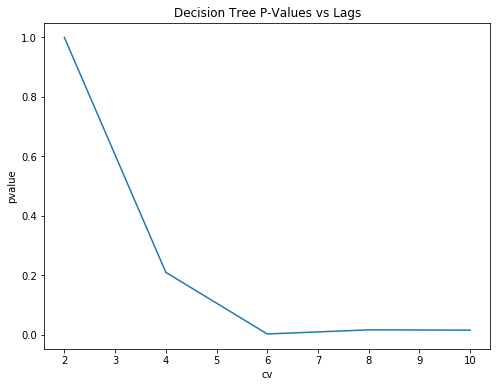

In [10]:
plt.figure(figsize=(8,6))
plt.plot(np.arange(2,12,2),p_value_list)
plt.title('Decision Tree P-Values vs Lags')
plt.xlabel('cv')
plt.ylabel('pvalue')
plt.show()

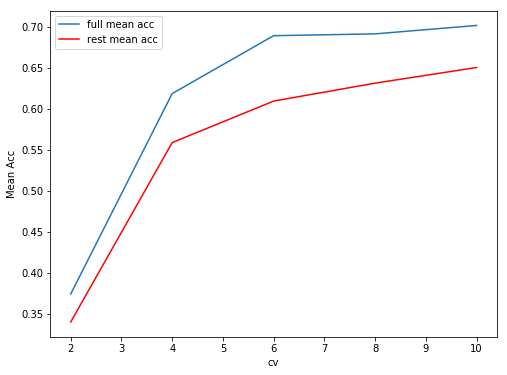

In [11]:
plt.figure(figsize=(8,6))
plt.plot(np.arange(2,12,2),mean_acc_full_list,label='full mean acc')
plt.plot(np.arange(2,12,2),mean_acc_red_list,color='r',label='rest mean acc')
plt.xlabel('cv')
plt.ylabel('Mean Acc')
plt.legend()
plt.show()

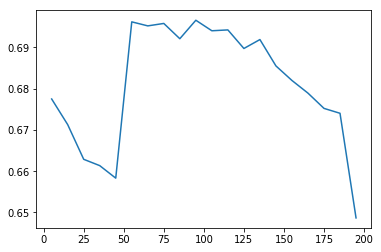

In [132]:
plt.plot(np.arange(5,200,10),mean_acc_red_list)
plt.show()

# Y Causes Z

In [14]:
dict_cls =  test_causality(dft_y,comp_y,va_y,dataset_z,dataset_combined_yz,comp_z,va_z,target_y,cv=cv)
resdf = pd.DataFrame(dict_cls).T
print('Mean Across Full Classifiers : ',resdf['Mean-Acc-Full'].mean())
print('Mean Across Reduced Classifiers : ',resdf['Mean-Acc-Reduced'].mean())
resdf

Mean Across Full Classifiers :  0.6348646119114765
Mean Across Reduced Classifiers :  0.6502738893879236


,Mean-Acc-Full,Mean-Acc-Reduced,P-Value
nb,0.644467,0.695018,0.697958
dt,0.595624,0.595624,1.000000
knn,0.777513,0.732154,0.622239
lr,0.521855,0.578300,0.717613


In [26]:
#Testing on datasets
clf = DecisionTreeClassifier(max_depth=2)
scores_red= cross_val_score(clf,dataset_z,target_x, cv=cv,scoring='accuracy')
scores_full= cross_val_score(clf,dataset_combined_xz,target_x, cv=cv,scoring='accuracy')
print('full',np.mean(scores_full))
print('red',np.mean(scores_red))

full 0.6121965424307977
red 0.6213300762569542


In [36]:
# g= sns.barplot(x=dataset_combined_xz.columns,y=c.feature_importances_)
# g.set_xticklabels(labels=dataset_combined_xz.columns,rotation=90)
# plt.title('Feature Importance based DT')
# plt.show()

# Aggergated Across Logs Files

In [28]:
datalist =os.listdir('../data')
lag = 25
cv = 7

In [35]:
dict_files = {} 
for i,log in enumerate(datalist):
    print('File:{} --  {} / {}'.format(log,i,len(datalist)-1))
    dft_x, dft_y, dataset_x, dataset_y, dataset_z, dataset_combined_xz, dataset_combined_yz, target_x, target_y = causality_cls_preprocess(x,y,z
    ,log[:-4], lag)
    if isinstance(dft_x,int):
        print('Signal Not Found in file')
        continue
    comp_y, va_y = signal_comp_va(y)
    comp_z, va_z = signal_comp_va(z)
    comp_x, va_x = signal_comp_va(x)
    try:
        dict_cls =  test_causality(dft_x,comp_x,va_x,dataset_z,dataset_combined_xz,comp_z,va_z,target_x,cv=cv)
    except:
        continue
    resdf = pd.DataFrame(dict_cls).T
    dict_files[log[:-4]] = { 'mean_full_acc' :resdf['Mean-Acc-Full'].mean() , 'mean_red_acc':resdf['Mean-Acc-Reduced'].mean() ,
                            'pvalue':resdf.loc['dt']['P-Value']}

File:568c058bb560505c22dc402c.log --  0 / 2607
File:568c0b3a7132fa902e401d31.log --  1 / 2607
File:568c0db17132fa902e401d33.log --  2 / 2607
File:568c0e8f7132fa902e401d34.log --  3 / 2607
File:568c0f4a7132fa902e401d35.log --  4 / 2607
Signal Not Found in file
File:56d75dd746a12d150ba9724f.log --  5 / 2607
File:56d7e5a546a12d150ba97250.log --  6 / 2607
File:56f69d8d85e739af3b3cb422.log --  7 / 2607
File:56f6af5385e739af3b3cb424.log --  8 / 2607
File:56f6af5b85e739af3b3cb425.log --  9 / 2607
File:56f6af6885e739af3b3cb426.log --  10 / 2607
File:56f6af7385e739af3b3cb427.log --  11 / 2607
File:5757cf85cf913b9b04694227.log --  12 / 2607
Signal Not Found in file
File:5757d3dfcf913b9b04694228.log --  13 / 2607
Signal Not Found in file
File:5757d47fcf913b9b04694229.log --  14 / 2607
Signal Not Found in file
File:575ce9d988bc9002549dfb5e.log --  15 / 2607
Signal Not Found in file
File:575eaeb288bc9002549dfb5f.log --  16 / 2607
Signal Not Found in file
File:575ec43488bc9002549dfb60.log --  17 / 2

Signal Not Found in file
File:5768498172ee277c7e5a2453.log --  126 / 2607
Signal Not Found in file
File:5768ddd972ee277c7e5a2456.log --  127 / 2607
File:5768eeec477dabbb3415a7d8.log --  128 / 2607
Signal Not Found in file
File:57690d375f861dd84e5d53f8.log --  129 / 2607
File:57691f2e5f861dd84e5d53f9.log --  130 / 2607
Signal Not Found in file
File:576927a65f861dd84e5d53fa.log --  131 / 2607
File:57696a625f861dd84e5d53fd.log --  132 / 2607
Signal Not Found in file
File:57696b305f861dd84e5d53fe.log --  133 / 2607
Signal Not Found in file
File:57697fcf5f861dd84e5d53ff.log --  134 / 2607
Signal Not Found in file
File:576980851a680f491f2bbf1d.log --  135 / 2607
Signal Not Found in file
File:57698a6e1a680f491f2bbf1f.log --  136 / 2607
File:576a983bc25d5f525499820e.log --  137 / 2607
File:576b6771c25d5f525499820f.log --  138 / 2607
Signal Not Found in file
File:576b6b3cc25d5f5254998211.log --  139 / 2607
File:576b96ccc25d5f5254998212.log --  140 / 2607
Signal Not Found in file
File:576bdf4dc2

Signal Not Found in file
File:577ab1f36b67d3bd6633f4e2.log --  248 / 2607
Signal Not Found in file
File:577b76596b67d3bd6633f4e4.log --  249 / 2607
Signal Not Found in file
File:577b9f7f6b67d3bd6633f4e6.log --  250 / 2607
File:577baeb46b67d3bd6633f4e7.log --  251 / 2607
File:577baf776b67d3bd6633f4e9.log --  252 / 2607
File:577bb31d6b67d3bd6633f4ea.log --  253 / 2607
File:577c1b646b67d3bd6633f4ec.log --  254 / 2607
Signal Not Found in file
File:577d52f75ea76af51d99646e.log --  255 / 2607
Signal Not Found in file
File:577d5b9d5ea76af51d996471.log --  256 / 2607
Signal Not Found in file
File:577d600a5ea76af51d996474.log --  257 / 2607
Signal Not Found in file
File:577ddca75ea76af51d996475.log --  258 / 2607
File:577e1a105ea76af51d996476.log --  259 / 2607
File:577e32a75ea76af51d996477.log --  260 / 2607
File:577e32b85ea76af51d996478.log --  261 / 2607
File:577e32c25ea76af51d996479.log --  262 / 2607
File:577e5e31e4db1be55b122497.log --  263 / 2607
File:577e60c9e4db1be55b122498.log --  264

Signal Not Found in file
File:578e5d4a3f58bbcd18ae0e6d.log --  370 / 2607
File:578e5de03f58bbcd18ae0e6f.log --  371 / 2607
File:578ee0f7cb333a2711f75e3b.log --  372 / 2607
File:578f17631a5be0de76564541.log --  373 / 2607
File:578f18201a5be0de76564542.log --  374 / 2607
File:578f18771a5be0de76564543.log --  375 / 2607
File:578f559306e7bfad71cf22ee.log --  376 / 2607
Signal Not Found in file
File:578fadb5b26c057d302144f8.log --  377 / 2607
Signal Not Found in file
File:578fbb42b26c057d302144fb.log --  378 / 2607
Signal Not Found in file
File:578fbbd1b26c057d302144fd.log --  379 / 2607
Signal Not Found in file
File:5790a16f3fa528a871ce8bec.log --  380 / 2607
Signal Not Found in file
File:5790a1c53fa528a871ce8bee.log --  381 / 2607
Signal Not Found in file
File:5790a2a33fa528a871ce8bef.log --  382 / 2607
Signal Not Found in file
File:5790a3883fa528a871ce8bf0.log --  383 / 2607
Signal Not Found in file
File:5790a9ec3fa528a871ce8bf1.log --  384 / 2607
Signal Not Found in file
File:5790cd03e9

File:57a0cf8f3c40f4a35e8e49ad.log --  499 / 2607
File:57a19457a514289c28c2eaf0.log --  500 / 2607
Signal Not Found in file
File:57a1b56188940b1b4bb263b1.log --  501 / 2607
Signal Not Found in file
File:57a23ad90633f43526e7748d.log --  502 / 2607
Signal Not Found in file
File:57a23b8f0633f43526e7748e.log --  503 / 2607
Signal Not Found in file
File:57a23cdf0633f43526e7748f.log --  504 / 2607
Signal Not Found in file
File:57a2c9f357ad704631edfe64.log --  505 / 2607
File:57a2d5ec57ad704631edfe65.log --  506 / 2607
File:57a2d80f57ad704631edfe67.log --  507 / 2607
Signal Not Found in file
File:57a32d1592d5faed49428e7a.log --  508 / 2607
File:57a32da992d5faed49428e7b.log --  509 / 2607
File:57a32deb92d5faed49428e7c.log --  510 / 2607
File:57a32e1692d5faed49428e7d.log --  511 / 2607
File:57a38649ed540b986eee1312.log --  512 / 2607
Signal Not Found in file
File:57a38b0eed540b986eee1313.log --  513 / 2607
Signal Not Found in file
File:57a38b58ed540b986eee1315.log --  514 / 2607
Signal Not Found

Signal Not Found in file
File:57b9e77924693bd53158a337.log --  625 / 2607
Signal Not Found in file
File:57b9e7c224693bd53158a338.log --  626 / 2607
Signal Not Found in file
File:57b9e86324693bd53158a33b.log --  627 / 2607
Signal Not Found in file
File:57b9e88724693bd53158a33c.log --  628 / 2607
Signal Not Found in file
File:57b9f47724693bd53158a33e.log --  629 / 2607
Signal Not Found in file
File:57ba1d3724693bd53158a33f.log --  630 / 2607
File:57bab9a90380a26a5be8c1c8.log --  631 / 2607
Signal Not Found in file
File:57bad5500380a26a5be8c1c9.log --  632 / 2607
File:57baf2c10380a26a5be8c1ca.log --  633 / 2607
Signal Not Found in file
File:57bb2c927aac90ad3c4eff24.log --  634 / 2607
Signal Not Found in file
File:57bb32287aac90ad3c4eff25.log --  635 / 2607
File:57bb3c5c7aac90ad3c4eff26.log --  636 / 2607
Signal Not Found in file
File:57bbf2cf7eb8c7bd16574bdd.log --  637 / 2607
File:57bc2684021f5e4b12ebef7f.log --  638 / 2607
File:57bc270b021f5e4b12ebef80.log --  639 / 2607
File:57bc27ec02

Signal Not Found in file
File:57d5951bb5b6a40132b32b0c.log --  753 / 2607
Signal Not Found in file
File:57d5e3ce61d7e8e65ef2bd6d.log --  754 / 2607
Signal Not Found in file
File:57d5e84212efdf6f03b1bfc9.log --  755 / 2607
Signal Not Found in file
File:57d68a6393e68bf409301e83.log --  756 / 2607
File:57d6e56dacca982c0f138a90.log --  757 / 2607
Signal Not Found in file
File:57d7acc4eb3c75586ef97592.log --  758 / 2607
File:57d7b398eb3c75586ef97593.log --  759 / 2607
Signal Not Found in file
File:57d7f8a5699f5b396fee683a.log --  760 / 2607
File:57d7facc699f5b396fee683b.log --  761 / 2607
File:57d8641b7bafed6d7f35a4ab.log --  762 / 2607
File:57d8801f6d0a034862463184.log --  763 / 2607
File:57d94049de9386471a3073ae.log --  764 / 2607
Signal Not Found in file
File:57d9904457aaa1f21f28dd5e.log --  765 / 2607
Signal Not Found in file
File:57da76a5fd69e0db28312117.log --  766 / 2607
Signal Not Found in file
File:57dab4e1864f9bd01c730cb9.log --  767 / 2607
Signal Not Found in file
File:57db6de2fd

Signal Not Found in file
File:57fbd65825224fc2365c4b80.log --  883 / 2607
Signal Not Found in file
File:57fbd68845b2623740409c52.log --  884 / 2607
Signal Not Found in file
File:57fbd6c645b2623740409c53.log --  885 / 2607
Signal Not Found in file
File:57fbda0545b2623740409c55.log --  886 / 2607
File:57fbeafd45b2623740409c56.log --  887 / 2607
File:57fbeb4145b2623740409c57.log --  888 / 2607
File:57fbfe4345b2623740409c58.log --  889 / 2607
File:57fc37bc4b8fc6793baddf55.log --  890 / 2607
File:57fcde47e0ee16dd7423a323.log --  891 / 2607
File:57fd0642c9d1de006c01d86f.log --  892 / 2607
Signal Not Found in file
File:57fd09911036c5ba0ea231b8.log --  893 / 2607
File:57fd11a11036c5ba0ea231b9.log --  894 / 2607
File:57fd2b4981be21315fa6663d.log --  895 / 2607
Signal Not Found in file
File:57fd2cd781be21315fa6663e.log --  896 / 2607
Signal Not Found in file
File:57fe48e812d7fa6e04b5ff40.log --  897 / 2607
File:57fe6fe7bd7e6c245b43fa38.log --  898 / 2607
Signal Not Found in file
File:57fe705abd7

Signal Not Found in file
File:5823472afc2e9d450b639947.log --  1020 / 2607
Signal Not Found in file
File:582362ebfc2e9d450b639948.log --  1021 / 2607
Signal Not Found in file
File:582377c7fc2e9d450b639949.log --  1022 / 2607
File:5824195efc2e9d450b63994a.log --  1023 / 2607
File:58241dd2fc2e9d450b63994b.log --  1024 / 2607
File:58242175fc2e9d450b63994c.log --  1025 / 2607
File:58242becfc2e9d450b63994f.log --  1026 / 2607
File:582496f8b208017d30e22f9d.log --  1027 / 2607
Signal Not Found in file
File:5824ae7fb208017d30e22f9e.log --  1028 / 2607
File:582549f49ef64a94617b169c.log --  1029 / 2607
File:5825b9cc3a09317034c07bcf.log --  1030 / 2607
Signal Not Found in file
File:5825d141dd613b243b09cb1a.log --  1031 / 2607
Signal Not Found in file
File:58260da8363345ce32dfd181.log --  1032 / 2607
File:5826dd5f516ad2465681bf57.log --  1033 / 2607
File:5826f64a4275d39463deb936.log --  1034 / 2607
File:5827710492f4225e6bbe1cf5.log --  1035 / 2607
Signal Not Found in file
File:58277efd92f4225e6bbe

File:58579d41498e70aa116f8ec6.log --  1146 / 2607
Signal Not Found in file
File:585b61e79e4ce84361ba05d0.log --  1147 / 2607
File:585b625bb88013406e6f6c52.log --  1148 / 2607
File:585d79374b35f4907875e052.log --  1149 / 2607
File:585d7aea4b35f4907875e053.log --  1150 / 2607
File:585eaf893ea71ae83a2fb6c1.log --  1151 / 2607
Signal Not Found in file
File:585eb48c3ea71ae83a2fb6c2.log --  1152 / 2607
File:585eb9445143253507872fe9.log --  1153 / 2607
File:585ec62d520e7a763e704b01.log --  1154 / 2607
File:585ec660520e7a763e704b02.log --  1155 / 2607
File:585ec87d520e7a763e704b03.log --  1156 / 2607
File:585ec9ce04ae6004565061a4.log --  1157 / 2607
Signal Not Found in file
File:585ecafb04ae6004565061a6.log --  1158 / 2607
File:585ecdf704ae6004565061a9.log --  1159 / 2607
File:585ed06c887619a7714a8676.log --  1160 / 2607
File:585ed93ba515ab700b7ebac8.log --  1161 / 2607
File:585ed9bea515ab700b7ebac9.log --  1162 / 2607
File:585feaaa99ee4b5e39c7420f.log --  1163 / 2607
Signal Not Found in file


File:58a88d4fbc6d01ae206e4509.log --  1271 / 2607
File:58a88ddfbc6d01ae206e450a.log --  1272 / 2607
File:58a88e3f7a8fe967268696f8.log --  1273 / 2607
File:58ab3667ed06bac328c5732a.log --  1274 / 2607
Signal Not Found in file
File:58ab395e434e47f12e09f948.log --  1275 / 2607
Signal Not Found in file
File:58ab3a13434e47f12e09f949.log --  1276 / 2607
Signal Not Found in file
File:58ab3a5a434e47f12e09f94a.log --  1277 / 2607
Signal Not Found in file
File:58ab3e35366761de481988b3.log --  1278 / 2607
Signal Not Found in file
File:58ab3e5e366761de481988b4.log --  1279 / 2607
Signal Not Found in file
File:58ab56394369335126016468.log --  1280 / 2607
Signal Not Found in file
File:58ab568d4369335126016469.log --  1281 / 2607
Signal Not Found in file
File:58ab71b75d2228da1da4e8bb.log --  1282 / 2607
File:58ac1e65de6f9a9225bd4592.log --  1283 / 2607
File:58ac97d0ded747ae57d25395.log --  1284 / 2607
File:58ac981ae1c906425cf96369.log --  1285 / 2607
File:58ac9e113a68f9be71bc8a03.log --  1286 / 2607


Signal Not Found in file
File:58d6dbb7c7993dae34585a9a.log --  1398 / 2607
Signal Not Found in file
File:58d6e7ee05cdfe636ac0884f.log --  1399 / 2607
Signal Not Found in file
File:58d7871ba93f32d104d22799.log --  1400 / 2607
Signal Not Found in file
File:58d78c07a93f32d104d2279a.log --  1401 / 2607
Signal Not Found in file
File:58d7cbe08b04a54c1829fe2d.log --  1402 / 2607
Signal Not Found in file
File:58d7efe1ba1653da0ae5a9c3.log --  1403 / 2607
Signal Not Found in file
File:58d81b36c100ce7d5db4f402.log --  1404 / 2607
Signal Not Found in file
File:58d81b5dc100ce7d5db4f403.log --  1405 / 2607
Signal Not Found in file
File:58d822816f16a6457678da84.log --  1406 / 2607
Signal Not Found in file
File:58d91ddc5a2699946f68b03e.log --  1407 / 2607
File:58d9360da8b821c855d1d2f7.log --  1408 / 2607
Signal Not Found in file
File:58d983087de050a00d37d044.log --  1409 / 2607
File:58d9844a7de050a00d37d045.log --  1410 / 2607
File:58d984c67de050a00d37d046.log --  1411 / 2607
File:58d99e03e88df7457430

File:58fe51ad93075ee84d66238e.log --  1527 / 2607
Signal Not Found in file
File:58fe6184b0d9f3517f5b6854.log --  1528 / 2607
Signal Not Found in file
File:58feee866b8d45326db551f2.log --  1529 / 2607
Signal Not Found in file
File:58feeec6f40999ac70709cc6.log --  1530 / 2607
Signal Not Found in file
File:58ff09af8a50e25b1624a1b3.log --  1531 / 2607
Signal Not Found in file
File:58ff48260f0cb889479bb914.log --  1532 / 2607
File:58ff66180f0cb889479bb915.log --  1533 / 2607
File:58ff74757e6243073ad1e8a6.log --  1534 / 2607
Signal Not Found in file
File:58ff759d7e6243073ad1e8a7.log --  1535 / 2607
Signal Not Found in file
File:58ff76577e6243073ad1e8aa.log --  1536 / 2607
Signal Not Found in file
File:58ffbf5342f5219f22a2e4b4.log --  1537 / 2607
Signal Not Found in file
File:59001e56ffc8597030be7294.log --  1538 / 2607
Signal Not Found in file
File:5900bb4f27a297340badb8a9.log --  1539 / 2607
Signal Not Found in file
File:5900ebb98c61da480595926c.log --  1540 / 2607
Signal Not Found in file


File:59122ce443deda0d77f5f2d8.log --  1652 / 2607
Signal Not Found in file
File:59122d6d43deda0d77f5f2d9.log --  1653 / 2607
Signal Not Found in file
File:59122f6643deda0d77f5f2da.log --  1654 / 2607
File:591244ff34847e1d2db19127.log --  1655 / 2607
Signal Not Found in file
File:5912452334847e1d2db19128.log --  1656 / 2607
Signal Not Found in file
File:5912a1a306f43bcc0f9baa57.log --  1657 / 2607
Signal Not Found in file
File:5912a1e406f43bcc0f9baa58.log --  1658 / 2607
Signal Not Found in file
File:5912a23406f43bcc0f9baa59.log --  1659 / 2607
Signal Not Found in file
File:5912df184dd84f2b08972b6f.log --  1660 / 2607
Signal Not Found in file
File:5912df2d4dd84f2b08972b70.log --  1661 / 2607
Signal Not Found in file
File:5912df3d4dd84f2b08972b71.log --  1662 / 2607
Signal Not Found in file
File:591301c0640019d50bfbedf7.log --  1663 / 2607
Signal Not Found in file
File:5913366a921e22e639ea1db1.log --  1664 / 2607
File:59133696921e22e639ea1db2.log --  1665 / 2607
File:5913775b81ffca922139

Signal Not Found in file
File:591de468f372186817cc67e2.log --  1777 / 2607
Signal Not Found in file
File:591dfa9b385a4a832fbf5f46.log --  1778 / 2607
Signal Not Found in file
File:591f04ec8739c42e1405f5f5.log --  1779 / 2607
File:591f158a07f0a4c632b0465c.log --  1780 / 2607
File:591f23d9427caa695e4df906.log --  1781 / 2607
Signal Not Found in file
File:591f282c857b1bb86ca5f501.log --  1782 / 2607
Signal Not Found in file
File:591f2b40857b1bb86ca5f502.log --  1783 / 2607
Signal Not Found in file
File:591f3b4f305abe8725946638.log --  1784 / 2607
Signal Not Found in file
File:591f4b938b298d7543f77ef9.log --  1785 / 2607
Signal Not Found in file
File:591fd8cf69105cb526006051.log --  1786 / 2607
File:591ffa209996fd8d5e3e2449.log --  1787 / 2607
File:59202615bb6c0c3b0323009b.log --  1788 / 2607
File:59202e6dbb6c0c3b0323009e.log --  1789 / 2607
File:59202f0cbb6c0c3b032300a0.log --  1790 / 2607
File:59203542bb6c0c3b032300a5.log --  1791 / 2607
File:59203aecbb6a8eca3c6c102c.log --  1792 / 2607


Signal Not Found in file
File:5939a0f6eae6cc41580cd651.log --  1903 / 2607
Signal Not Found in file
File:5939a2b3eae6cc41580cd652.log --  1904 / 2607
Signal Not Found in file
File:593a05c37f78401445847f4b.log --  1905 / 2607
File:593a72343cdea28c72b7ac76.log --  1906 / 2607
Signal Not Found in file
File:593abeff4504fbc6180b4934.log --  1907 / 2607
File:593b8797bd8cc3c3518fcf7d.log --  1908 / 2607
File:593c21d166dcbe9b55567822.log --  1909 / 2607
Signal Not Found in file
File:593c227e66dcbe9b55567823.log --  1910 / 2607
Signal Not Found in file
File:593c34ff96f2f40f7a7b2d30.log --  1911 / 2607
Signal Not Found in file
File:593c36c296f2f40f7a7b2d31.log --  1912 / 2607
Signal Not Found in file
File:593c56bac20295b866d01912.log --  1913 / 2607
File:593ce35c91038c594306ee85.log --  1914 / 2607
Signal Not Found in file
File:593ce50291038c594306ee86.log --  1915 / 2607
File:593d2d618b83c4341b5550e5.log --  1916 / 2607
Signal Not Found in file
File:593d2da38b83c4341b5550e6.log --  1917 / 2607


File:595483d365543f1c7f3e2b08.log --  2029 / 2607
File:595484b565543f1c7f3e2b09.log --  2030 / 2607
File:595484e365543f1c7f3e2b0a.log --  2031 / 2607
File:5954852d65543f1c7f3e2b0b.log --  2032 / 2607
File:5954856565543f1c7f3e2b0c.log --  2033 / 2607
File:595485c065543f1c7f3e2b0d.log --  2034 / 2607
File:595485fe65543f1c7f3e2b0e.log --  2035 / 2607
File:5954864665543f1c7f3e2b0f.log --  2036 / 2607
File:5954867865543f1c7f3e2b10.log --  2037 / 2607
File:5954b686485d838173e28253.log --  2038 / 2607
Signal Not Found in file
File:5954b9b83fe22c4c2045e7bc.log --  2039 / 2607
Signal Not Found in file
File:5954bbe83fe22c4c2045e7bd.log --  2040 / 2607
File:5954d00cd6c203f34fea4347.log --  2041 / 2607
File:5954d15ed6c203f34fea4348.log --  2042 / 2607
Signal Not Found in file
File:5954dbf79451fbb5662adede.log --  2043 / 2607
File:59552499a7cac98d7c1e990f.log --  2044 / 2607
Signal Not Found in file
File:59552af009f65ea83f1df554.log --  2045 / 2607
File:5955450fd8fca72c544a1cc8.log --  2046 / 2607


Signal Not Found in file
File:5967c4b83c4fffa34e92b06f.log --  2153 / 2607
Signal Not Found in file
File:5967c7263c4fffa34e92b070.log --  2154 / 2607
Signal Not Found in file
File:5967c7a63c4fffa34e92b071.log --  2155 / 2607
Signal Not Found in file
File:5967c8363c4fffa34e92b072.log --  2156 / 2607
Signal Not Found in file
File:5967f570688e15c6314e73f1.log --  2157 / 2607
File:59680a3c6091be2709c233a4.log --  2158 / 2607
Signal Not Found in file
File:59680b046091be2709c233a5.log --  2159 / 2607
Signal Not Found in file
File:5968c36bc9f669fd5c060444.log --  2160 / 2607
File:5968c3d9c9f669fd5c060446.log --  2161 / 2607
File:5968e323a65ebf6a311bf042.log --  2162 / 2607
Signal Not Found in file
File:5968e382a65ebf6a311bf043.log --  2163 / 2607
Signal Not Found in file
File:5968f8ae41d07ee8609b929e.log --  2164 / 2607
File:596907fb3acef2f010d8258f.log --  2165 / 2607
Signal Not Found in file
File:596955ff094ab9476ce21db1.log --  2166 / 2607
File:59695635094ab9476ce21db2.log --  2167 / 2607


Signal Not Found in file
File:597ec44be52d4b8429c4b3e0.log --  2276 / 2607
Signal Not Found in file
File:597f196a385204f121603b9c.log --  2277 / 2607
Signal Not Found in file
File:597f196f385204f121603b9d.log --  2278 / 2607
Signal Not Found in file
File:597f33dcbf303a2f5950d94d.log --  2279 / 2607
File:597f473a974ad5e22010f421.log --  2280 / 2607
Signal Not Found in file
File:597ff76f93174c226936fc31.log --  2281 / 2607
File:597ff94993174c226936fc32.log --  2282 / 2607
File:5981601d1962a6531d6a3e97.log --  2283 / 2607
Signal Not Found in file
File:5981606e1962a6531d6a3e98.log --  2284 / 2607
Signal Not Found in file
File:5981a290ca8fd93d58bb4628.log --  2285 / 2607
Signal Not Found in file
File:598230c425775e075035d753.log --  2286 / 2607
Signal Not Found in file
File:598234714fba09e555464769.log --  2287 / 2607
File:598234a74fba09e55546476a.log --  2288 / 2607
Signal Not Found in file
File:598234c24fba09e55546476b.log --  2289 / 2607
Signal Not Found in file
File:598257e03754946815f9

Signal Not Found in file
File:59983679085e384d320f9f91.log --  2397 / 2607
Signal Not Found in file
File:599836fdd483d5c138a965b4.log --  2398 / 2607
Signal Not Found in file
File:5998d3e51da4536265df0eed.log --  2399 / 2607
Signal Not Found in file
File:5999a8794ec335fa2eb0dacc.log --  2400 / 2607
Signal Not Found in file
File:5999a91d58feccd8359b72e5.log --  2401 / 2607
File:599b2c845c16a6a73d8c986f.log --  2402 / 2607
Signal Not Found in file
File:599c182bc080c00c6ebc0b01.log --  2403 / 2607
Signal Not Found in file
File:599c188a60f6cbcd4b100019.log --  2404 / 2607
Signal Not Found in file
File:599c3c5ad55e02dc0fc7de26.log --  2405 / 2607
File:599c4d782e7a36075fc981c2.log --  2406 / 2607
Signal Not Found in file
File:599c835940dec49b6570fde8.log --  2407 / 2607
File:599f9e4ed8feb5be2cc1638b.log --  2408 / 2607
File:599ffd43499babae112dfaab.log --  2409 / 2607
Signal Not Found in file
File:59a12bc42c49b4164e831c19.log --  2410 / 2607
Signal Not Found in file
File:59a12c0e2c49b4164e83

Signal Not Found in file
File:59eac85c39dc61061378c68f.log --  2527 / 2607
Signal Not Found in file
File:59eac88739dc61061378c690.log --  2528 / 2607
Signal Not Found in file
File:59ebaf838a30690f0d538747.log --  2529 / 2607
Signal Not Found in file
File:59ebbddef6f9db5b74aff006.log --  2530 / 2607
File:59ebbeaaf6f9db5b74aff007.log --  2531 / 2607
File:59ec21f07d982a9e5f2193dc.log --  2532 / 2607
Signal Not Found in file
File:59ece31d45f3a8246a4b9e2d.log --  2533 / 2607
File:59edc5aee57133c0421b9179.log --  2534 / 2607
Signal Not Found in file
File:59eec30873c723cc1ee15b98.log --  2535 / 2607
Signal Not Found in file
File:59ef86f507d4dd8b287cdb42.log --  2536 / 2607
Signal Not Found in file
File:59ef8bc107d4dd8b287cdb44.log --  2537 / 2607
Signal Not Found in file
File:59ef8cae07d4dd8b287cdb45.log --  2538 / 2607
Signal Not Found in file
File:59ef8e101e0ff1be5ec9ebfe.log --  2539 / 2607
Signal Not Found in file
File:59efa1f7d14ff8c03b6d3dd9.log --  2540 / 2607
File:59efa2e0d14ff8c03b6d

In [37]:
dt_seg = dict_files.copy()
save_as_pickle(dt_seg,'pickle','dt_means.pickle')

Save dt_means.pickle successfully.


In [39]:
df = pd.DataFrame(dt_seg).T

In [41]:
df.describe()

,mean_full_acc,mean_red_acc,pvalue
count,911.000000,911.000000,911.000000
mean,0.627594,0.631437,0.640494
std,0.099995,0.099075,0.308715
min,0.339362,0.368086,0.000002
25%,0.560788,0.566538,0.394179
50%,0.612846,0.620296,0.708806
75%,0.678252,0.675363,0.930835
max,0.973054,0.976861,1.000000


In [45]:
(sum(df['pvalue'] <= 0.05 )/len(df)) *100

4.281009879253568

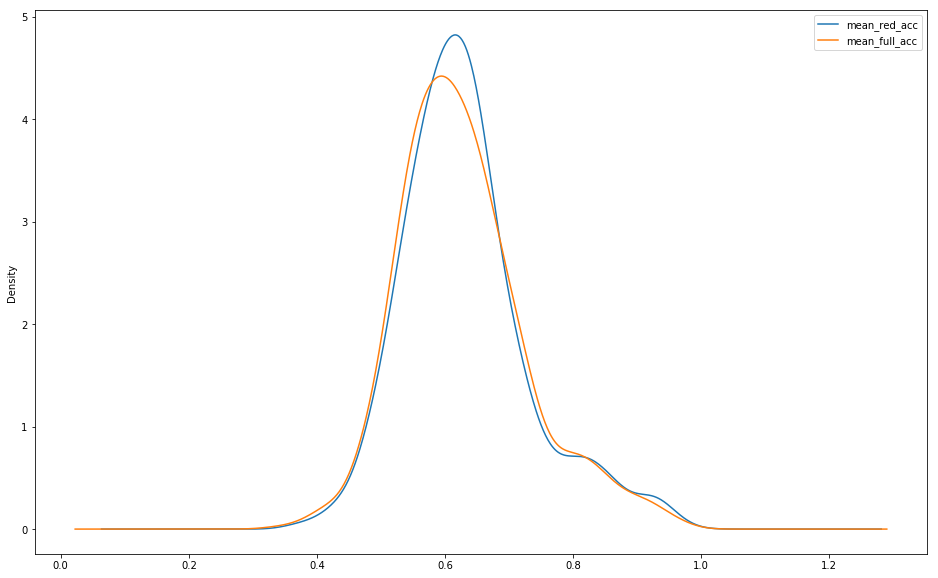

In [42]:
plt.figure(figsize=(16,10))
df['mean_red_acc'].plot(kind='kde')
df['mean_full_acc'].plot(kind='kde')
plt.legend()